In [37]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train = pd.read_csv('train_clean.csv')
val = pd.read_csv('val_clean.csv')

train

,review,rating,review_clean
0,Ga disappointed neat products .. Meletot Hilsn...,1,ga disappointed neat products . meletot hilsn...
1,"Rdtanya replace broken glass, broken chargernya",1,rdtanya replace broken glass. broken chargernya
2,Nyesel bngt dsni shopping antecedent photo mes...,1,nyesel bngt dsni shopping antecedent photo mes...
3,Sent a light blue suit goods ga want a refund,1,sent a light blue suit goods ga want a refund
4,Pendants came with dents and scratches on its ...,1,pendants came with dents and scratches on its ...
...,...,...,...
106881,Thanks you very satisfactory,5,thanks you very satisfactory
106882,Excellent quality Excellent quality Very acco...,5,excellent quality excellent quality very acco...
106883,Excellent product quality delivery speed is ve...,5,excellent product quality delivery speed is ve...
106884,thanks gan,5,thanks gan


In [21]:
ratings = train['rating'].unique()
NUM_SAMPLE = 20000
train_balanced = pd.DataFrame(columns = train.columns)

for rating in ratings:
    sub_df = train[train['rating'] == rating]
    sub_df_fixed = sub_df.copy()

    duplicate_time = int(NUM_SAMPLE / len(sub_df))
    for _ in range(duplicate_time): sub_df = pd.concat([sub_df, sub_df_fixed])

    sub_df = sub_df.sample(NUM_SAMPLE)
    train_balanced = pd.concat([train_balanced, sub_df])

train_balanced = train_balanced.reset_index(drop=True)
train_balanced

,review,rating,review_clean
0,dc 2 times wearing that ruffled the cloth off....,1,dc 2 times wearing that ruffled the cloth off....
1,"sdkit similar latch was broken, tp Okay",1,sdkit similar latch was broken. tp okay
2,Defective color adhesive 2 surface coat said t...,1,defective color adhesive 2 surface coat said t...
3,Goods which sent handicapped,1,goods which sent handicapped
4,"I buy 10 items, items that are not sent, the s...",1,i buy 10 items. items that are not sent. the...
...,...,...,...
99995,Recommended .. really cheap price but not chea...,5,recommended . really cheap price but not chea...
99996,"Thanks goods are complete, there is no reply b...",5,thanks goods are complete. there is no reply ...
99997,Thank you received SDH goods ... although coul...,5,thank you received sdh goods . although could...
99998,"Excellent product quality, product prices are ...",5,excellent product quality. product prices are...


In [22]:
train_data = train_balanced['review_clean'].to_numpy()
train_label = train_balanced['rating'].astype(np.float32).to_numpy() - 1
val_data = val['review_clean'].to_numpy()
val_label = val['rating'].to_numpy() - 1

In [23]:
model_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
hub_layer = hub.KerasLayer(model_url, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=False)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 124,644,837
Trainable params: 2,149
Non-trainable params: 124,642,688
_________________________________________________________________


In [25]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_label))

for data, label in train_ds.take(1):
    print(data)
    print(label)

tf.Tensor(b'dc 2 times wearing that ruffled the cloth off.  loose pants off.  yet that money', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float32)


In [27]:
BATCH_SIZE = 256
train_ds = train_ds.cache().shuffle(len(train_balanced)).batch(BATCH_SIZE)
val_ds = val_ds.cache().batch(BATCH_SIZE)

In [28]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10
391/391 [==============================] - 3s 8ms/step - loss: 1.3181 - accuracy: 0.4020 - val_loss: 1.3059 - val_accuracy: 0.4057
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2774 - accuracy: 0.4178 - val_loss: 1.3026 - val_accuracy: 0.4051
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2666 - accuracy: 0.4232 - val_loss: 1.3000 - val_accuracy: 0.4014
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2597 - accuracy: 0.4265 - val_loss: 1.2960 - val_accuracy: 0.4084
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2551 - accuracy: 0.4284 - val_loss: 1.2930 - val_accuracy: 0.4056
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2502 - accuracy: 0.4304 - val_loss: 1.2899 - val_accuracy: 0.4114
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2479 - accuracy: 0.4312 - val_loss: 1.2933 - val_accuracy: 0.4136
Epoch 

In [29]:
hub_layer.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 124,644,837
Trainable params: 124,644,837
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2411 - accuracy: 0.4349 - val_loss: 1.2930 - val_accuracy: 0.4100
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2394 - accuracy: 0.4358 - val_loss: 1.2963 - val_accuracy: 0.4111
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2391 - accuracy: 0.4349 - val_loss: 1.2937 - val_accuracy: 0.4098
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2389 - accuracy: 0.4350 - val_loss: 1.2949 - val_accuracy: 0.4120
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2375 - accuracy: 0.4376 - val_loss: 1.2950 - val_accuracy: 0.4122
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2369 - accuracy: 0.4350 - val_loss: 1.2989 - val_accuracy: 0.4127
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2368 - accuracy: 0.4346 - val_loss: 1.2969 - val_accuracy: 0.4131
Epoch 

In [31]:
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10
391/391 [==============================] - 4s 10ms/step - loss: 1.1965 - accuracy: 0.4529 - val_loss: 1.2413 - val_accuracy: 0.4349
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 1.1550 - accuracy: 0.4717 - val_loss: 1.2278 - val_accuracy: 0.4433
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 1.1305 - accuracy: 0.4822 - val_loss: 1.2228 - val_accuracy: 0.4409
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 1.1108 - accuracy: 0.4894 - val_loss: 1.2195 - val_accuracy: 0.4471
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 1.0942 - accuracy: 0.4965 - val_loss: 1.2171 - val_accuracy: 0.4477
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 1.0790 - accuracy: 0.5045 - val_loss: 1.2214 - val_accuracy: 0.4476
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 1.0645 - accuracy: 0.5114 - val_loss: 1.2210 - val_accuracy: 0.4487

In [33]:
logits = model.predict(val_ds)

In [34]:
probs = tf.nn.softmax(logits).numpy()
labels_pred = np.argmax(probs, axis=1)

print('True labels: ', val_label[:10])
print('Predicted labels: ', labels_pred[:10])

True labels:  [0 0 0 0 0 0 0 0 0 0]
Predicted labels:  [0 4 2 0 0 0 0 0 0 0]


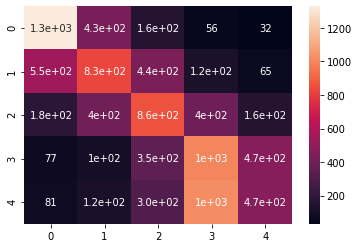

In [39]:
conf_matrix = tf.math.confusion_matrix(val_label, labels_pred).numpy()
sns.heatmap(conf_matrix, annot=True)

In [40]:
test = pd.read_csv('test_clean.csv')
test

,review_id,review,review_clean
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger. cool. motif and cantik2 jg mod...
1,2,One of the shades don't fit well,one of the shades don't fit well
2,3,Very comfortable,very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast delivery. product expiry is on dec 2022....
4,5,it's sooooo cute! i like playing with the glit...,it's sooooo cute. i like playing with the gli...
...,...,...,...
60422,60423,Product has been succesfully ordered and shipp...,product has been succesfully ordered and shipp...
60423,60424,Opening time a little scared. Fear dalemnya de...,opening time a little scared. fear dalemnya d...
60424,60425,The product quality is excellent. The origina...,the product quality is excellent. the origin...
60425,60426,They 're holding up REALLY well also .,they 're holding up really well also .


In [41]:
test_ds = tf.data.Dataset.from_tensor_slices((test['review_clean']))
test_ds = test_ds.batch(BATCH_SIZE)

In [49]:
logits = model.predict(test_ds)

In [50]:
probs = tf.nn.softmax(logits).numpy()
labels_pred = np.argmax(probs, axis=1)
len(labels_pred)

60427

In [51]:
test['rating'] = pd.Series(labels_pred + 1).astype(int)
test

,review_id,review,review_clean,rating
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger. cool. motif and cantik2 jg mod...,3
1,2,One of the shades don't fit well,one of the shades don't fit well,2
2,3,Very comfortable,very comfortable,5
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast delivery. product expiry is on dec 2022....,3
4,5,it's sooooo cute! i like playing with the glit...,it's sooooo cute. i like playing with the gli...,4
...,...,...,...,...
60422,60423,Product has been succesfully ordered and shipp...,product has been succesfully ordered and shipp...,4
60423,60424,Opening time a little scared. Fear dalemnya de...,opening time a little scared. fear dalemnya d...,1
60424,60425,The product quality is excellent. The origina...,the product quality is excellent. the origin...,4
60425,60426,They 're holding up REALLY well also .,they 're holding up really well also .,5


In [52]:
test.loc[:, ['review_id', 'rating']].to_csv('submission.csv', index=False)